<a href="https://colab.research.google.com/github/gabrieladamasceno/AM_Desafio07/blob/main/Desafio_07_Pipeline_Ci%C3%AAncia_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Desafio 07 - Pipeline Ciência de Dados**

Professor: Cleber Zanchettin

Aluna: Maria Gabriela Lima Damasceno

#Introdução

O objetivo da atividade era escolher construir um pipeline de ciência de dados com o treinamento de um modelo para resolver o problema do dataset [Shopee - Price Match Guarantee](https://www.kaggle.com/competitions/shopee-product-matching), onde existem várias imagens de produtos da shopee semelhantes, mas com descrições que não são tão parecidas, utilizando o aprendizado siâmes é possível encontrar qual imagem é semelhante com a âncora, o objeto base em questão que se busca analisar.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Carregamento de Dados
O dataset escolhido estava em formato de planilhas (.csv) e pode ser lido e armazenado através da biblioteca do pandas. As imagens também estavam no formato JPEG e podiam ser acessadas através do código que estava na coluna "image" do arquivo CSV. O Dataset pode ser importado do Kaggle através da API e dos comandos a seguir.

In [ ]:
!pip install kaggle;

#Importa o token da API do Kaggle
from google.colab import files
files.upload() #enviar o arquivo kaggle.json

#Crias as pastas de armazenamento do dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Alterar a permissão para evitar o aviso durante a partida da ferramenta Kaggle
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#Aceitar a competição e copiar o endereço da API para o download do dataset
!kaggle competitions download -c shopee-product-matching

#Descompactar o arquivo baixado
!unzip \*.zip  && rm *.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train_images/d8fce6d90ff1c758810b2132d8d9a84e.jpg  
  inflating: train_images/d90143423d8db45b382f2dee3d01fcb1.jpg  
  inflating: train_images/d903b2ab37c0418bfeb7e6e5304b64a4.jpg  
  inflating: train_images/d905748b1f61121cdcc7ae397b97052b.jpg  
  inflating: train_images/d906df4fdf70397d4f04ef0fe6ea1fe2.jpg  
  inflating: train_images/d9074f43948053971953322ed8ddc2cf.jpg  
  inflating: train_images/d9076a1375bb05c33edd5a1f1684e1f0.jpg  
  inflating: train_images/d9093fbb00a2013aad7cbcd993d779ab.jpg  
  inflating: train_images/d90ac3ff5b7d6371c50b3ef737002084.jpg  
  inflating: train_images/d90c105714e1475c4ef930e796570749.jpg  
  inflating: train_images/d90e64bea620d6e38ffe9f35b276c192.jpg  
  inflating: train_images/d9149fbfdf8d8d197f86e0a3d2ab7584.jpg  
  inflating: train_images/d914f6199e2dbafdd4a519c48dd1a5f4.jpg  
  inflating: train_images/d9159234afcf810fa9ddc7b2d49ce707.jpg  
  inflating: train_images/d9163

#Análise Descritiva

As bibliotecas utilizadas para o modelo foram principalmente as do numpy, pandas e matplotlib, que já são bastante utilizadas na área de ciência de dados.

A principal biblioteca é a do Pytorch que dentre os diversos modelos que possui tem o de aprendizado siamês que será o usado no experimento.

In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms as T

pd.options.mode.chained_assignment = None

# Pré-Processamento
O CSV é carregado através do pandas e os cinco primeiros itens podem ser lidos com da função head().

In [ ]:
df = pd.read_csv('/content/train.csv')
df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


#Transformação dos Dados

As colunas 'labels_group', 'image' e 'posting_id' fazer parte do arquivo CSV e fazem referência ao número do grupo da imagem, ao código da imagem em JPEG e código da amostra no treino.

Através das colunas de 'labels_group' e 'posting_id' são correlacionadas os grupos do objetos das imagens com os códigos do dataset de treino.

In [ ]:
import numpy as np
from tqdm import tqdm

def choice(data):
    data['Positive'] = np.zeros(len(data))
    data['Negative'] = np.zeros(len(data))
    data = data.rename(columns={'labels_group': 'label_group', 'image': 'Anchor'})

    for _, row in tqdm(data.iterrows(), total=len(data)):
        lg = row['label_group']
        A_choice = row['Anchor']
        img_id = row['posting_id']

        try:
            P_choice = data['posting_id'][data['label_group'] == lg].values
        except:
            P_choice = [img_id]

        if len(P_choice) == 1:
            data.at[row.name, 'Positive'] = data['Anchor'][data['posting_id'] == P_choice[0]].values[0]
        else:
            p_flag = True
            n_flag = True

            while p_flag:
                P_choice = np.random.choice(data['posting_id'][data['label_group'] == lg].values)

                if img_id == P_choice:
                    p_flag = True
                else:
                    data.at[row.name, 'Positive'] = data['Anchor'][data['posting_id'] == P_choice].values[0]
                    p_flag = False

            while n_flag:
                N_choice = np.random.choice(data['Anchor'].values)

                if (N_choice == A_choice) or (N_choice == P_choice):
                    n_flag = True
                else:
                    data.at[row.name, 'Negative'] = N_choice
                    n_flag = False

    return data

Através da função choice() que seleciona a âncora e encontra os positivos e negativos através do CSV, é criado um dataframe do modelo siamês apenas com a coluna 'image'.

In [ ]:
df_siamese = choice(df)

100%|██████████| 34250/34250 [03:08<00:00, 181.94it/s]


In [ ]:
df_siamese = df_siamese.drop(['label_group','posting_id','image_phash','title'],axis = 1)
df_siamese.head()

,Anchor,Positive,Negative
0,0000a68812bc7e98c42888dfb1c07da0.jpg,f83b49a86a0ee8592e3bf0204da3fbdf.jpg,bbbb17dc02084ccdea3898196acc5b4e.jpg
1,00039780dfc94d01db8676fe789ecd05.jpg,8cbe4bf9706bc177fd61071ef776be8c.jpg,4e05b4f06ad08e1944926f2f86fa8f1f.jpg
2,000a190fdd715a2a36faed16e2c65df7.jpg,75dbd1e9f31f2d0f21d31c08b3e0b94e.jpg,aa73f68d22011d9a78a3ade4591f6d71.jpg
3,00117e4fc239b1b641ff08340b429633.jpg,52f5b2e6f6647325817eb99db17709f0.jpg,f8ba74ad4a0b05df136da2c7ad9aca3b.jpg
4,00136d1cf4edede0203f32f05f660588.jpg,8b0e60baf319fa282242ab1739df10e0.jpg,6453cddb87abdd6b06378aed10db7534.jpg


# Treinamento

A classe APN é utilizada com um modelo siamês, com uma imagem sendo a Âncora (A), a imagem relacionada a Positiva (P) e a não relacionada a Negativa (N), para cada amostra no conjunto de dados. As funções presentes na classe são:

* __ init __(): O método de inicialização que contém o DataFrame (df) e o diretório raiz (root_dir) onde as imagens estão armazenadas;

* __ len __(): Retorna o número total de amostras;

* __ getitem __(): Obtém uma amostra específica do conjunto de dados com base no índice fornecido (idx).

In [ ]:
import imageio
class APN(Dataset):

    def __init__(self,df,root_dir,transform = None):

        self.APN = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.ANP)

    def __getitem__(self,idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        A_name = os.path.join(self.root_dir,self.APN.iloc[idx,0])
        P_name = os.path.join(self.root_dir,self.APN.iloc[idx,1])
        N_name = os.path.join(self.root_dir,self.APN.iloc[idx,2])

        #Âncora, Positivo e Negativo
        A = io.imread(A_name)
        P = io.imread(P_name)
        N = io.imread(N_name)


        if self.transform:
            sample = self.transform((A,P,N))
            A,P,N = sample

        return A,P,N

Já a classe ToTensor() implementa a transformação para converter arrays NumPy em tensores PyTorch. A função __ call __() realiza a transformação das dimensões para corresponder ao formato esperado pelo PyTorch, que depois também são redimensionadas para um tamanho 512x512.

In [ ]:
class ToTensor(object):

    def __call__(self,sample):

        A,P,N = sample

        A = A.transpose((2,0,1))
        P = P.transpose((2,0,1))
        N = N.transpose((2,0,1))

        return torch.from_numpy(A),torch.from_numpy(P),torch.from_numpy(N)

class Resize(object):

    def __init__(self,*img_size):
        self.img_size = img_size

    def __call__(self,sample):

        A,P,N = sample

        A = transform.resize(A,self.img_size)
        P = transform.resize(P,self.img_size)
        N = transform.resize(N,self.img_size)

        return A,P,N


custom_transform = T.Compose([
    Resize(512,512),
    ToTensor()
])

# Resultados

Por fim, é possível chamar a função APN para ser utilizada com o diretório onde estão armazenadas as imagens em JPEG para serem treinadas no modelo siamês.

In [ ]:
siamese_data = APN(df_siamese,'/content/train_images',transform = custom_transform)

Colocando índices de zero até o número total de amostras é possível estabelecer âncoras e encontrar as imagens positivas que se assemelham a elas, assim como também mostrar exemplos de imagens negativas.

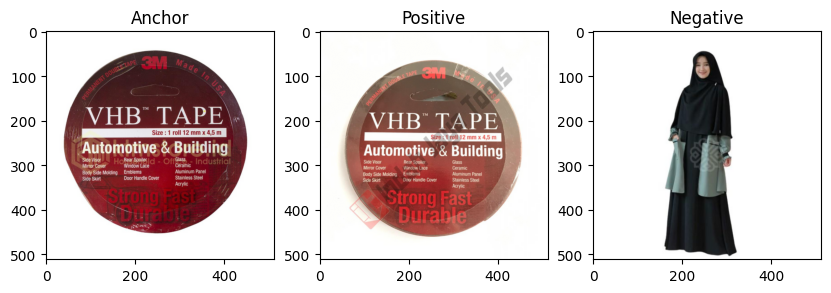

In [ ]:
idx = 1
A,P,N = siamese_data[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

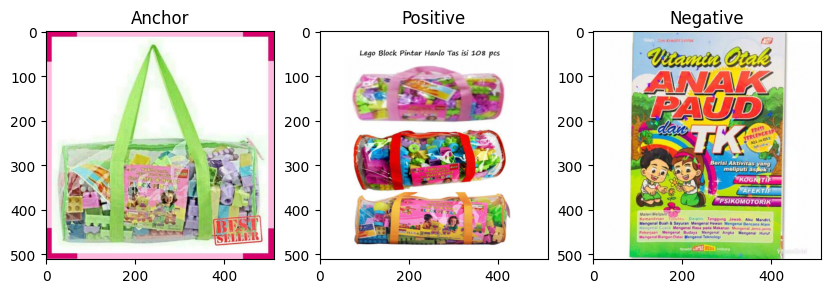

In [ ]:
idx = 2222
A,P,N = siamese_data[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

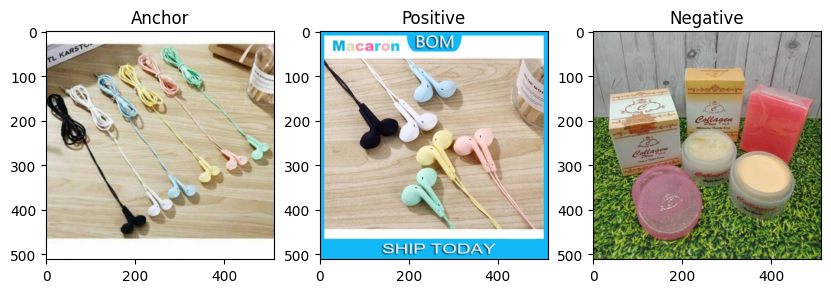

In [ ]:
idx = 9999
A,P,N = siamese_data[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')

ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

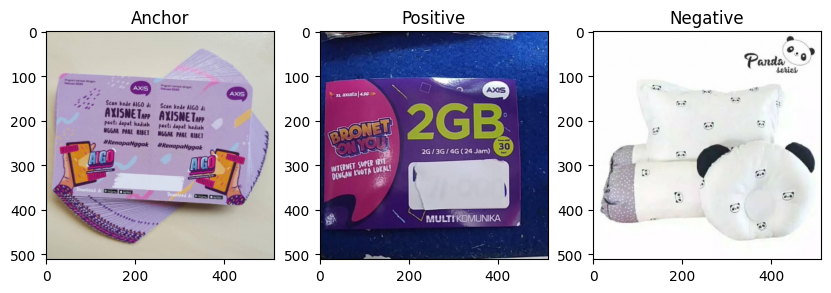

In [ ]:
idx = 30000
A,P,N = siamese_data[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

In [ ]:
criterion = torch.nn.TripletMarginLoss()
criterion(A,P,N)

tensor(4.1260, dtype=torch.float64)

#Conclusão

Desta forma, através dos experimentos foi possível constatar que o modelo de aprendizado siamês é excelente para problemas de deep learning relacionados a correlacionar imagens uma com as outras, partindo do ponto inicial de uma âncora, uma amostra base, para encontrar amostras que sejam parecidas.

Esse tipo de aprendizado mostra-se bastante eficáz para o problema proposto das compras online já que, por mais que a descrição dos produtos tenha uma variação, pelas imagens é possível identificar os itens de mesmo grupo, auxiliando na exposição de produtos semelhantes ao usuário do site.